In [1]:
import os
import sys
sys.path.append(os.path.abspath(".."))
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# mpl.style.use("bmh")
import seaborn as sns
import networkx as nx
import missingno as msno
%matplotlib inline

from speclib.loaders import loadUser, loadUserPhonenumberDict, getUserList, Useralias
from speclib.plotting import looseAxesLimits


In [2]:
def linkUser(userDct, linkDctLst, phDct):
    """Links users in the project with each other.
    
    Args:
        userDct (dict): Dictionary with sms and call entries.
        linkDctLst (defaultdict(Counter)): Defaultdict with counter-factory
                                           to provide history.
        phDct (dict): Dictionary with phoneID -> userID for participants in the project.
        
    Returns:
        (float, float): Fraction of (calls, sms) to participants in the project.
    """
    def updateDict(commLst, linkDct, numberIndexStr):
        inProjectCEvent = 0  # initialize counter
        # Loop over communication events
        if commLst is None:
            return None
        for event in commLst:
            contactedNumber = event[numberIndexStr]
            user = event["user"]
            if contactedNumber in phDct:  # if number belongs to a participant in the project
                inProjectCEvent += 1
                contactedUser = phDct[contactedNumber]
                # Remember: it's a counter inside the defaultdict
                linkDct[user][contactedUser] += 1
        return inProjectCEvent

    # for call, index to phone number is "number", for sms it's "address"
    numberTypePairTuple = (("call", "number"), ("sms", "address"))
    inProjectFractions = list()  # Count communications to participants
    # Three indexes: ("call"/"sms"), ("number"/"address"), (associated defaultdict()
    for (commType, numberIndexStr), linkDct in zip(numberTypePairTuple, linkDctLst):
        count = updateDict(userDct[commType], linkDct, numberIndexStr)
        # Turn counts info fraction of communication between participants
        if count is None:
            inProjectFractions.append(None)
            continue
        try:
            inProjectFractions.append(count / len(userDct[commType]))
        except ZeroDivisionError:
            inProjectFractions.append(None)
    return inProjectFractions

Load all users and get fraction of communications made to people in the study.

In [3]:
phDct = loadUserPhonenumberDict()
userLst = getUserList()

callDct, smsDct = defaultdict(Counter), defaultdict(Counter)

smsFracArr = np.zeros(len(userLst))
callFracArr = np.zeros(len(userLst))
for i, user in enumerate(userLst):
    try:
        userDct = loadUser(user, dataFilter=("call", "sms"))
        callFrac, smsFrac = linkUser(userDct, (callDct, smsDct), phDct)
        callFracArr[i] = callFrac
        smsFracArr[i] = smsFrac
        if i % 50 == 0:
            print("{:.0f} %".format(100 * i / len(userLst)), end="\t")
    except Exception as e:
        print("\n\n\nSomething went wrong  at (user, index):\n", user, i)
        raise e
print("100 %")

0 %	5 %	9 %	14 %	19 %	24 %	28 %	33 %	38 %	42 %	47 %	52 %	57 %	61 %	66 %	71 %	75 %	80 %	85 %	90 %	94 %	99 %	100 %


In [4]:
def aliasUsernames(commDct, useralias):
    """Convert human unreadable user names to sequentially generated aliases.
    Will also convert the dict[Counter] to dict[dict].
    
    Args:
        commDct (dict): Dict with dicts of communication events (call or sms)
        useralias (Class instance): An instance of the Useralias class.
        Used for generating and formatting the aliases.
    
    Returns:
        dict[dict]: Like the input, but with uliases for all usernames.
    """
    outDct = dict()
    for ko, vo in commDct.items():
        kon = useralias[ko]
        inner = dict()
        for ki, vi in vo.items():
            inner[useralias[ki]] = vi
        outDct[kon] = inner
    return outDct


ua = Useralias()
callDct2 = aliasUsernames(callDct, ua)
smsDct2 = aliasUsernames(smsDct, ua)

In [5]:
callFracArr = callFracArr[np.logical_not(np.isnan(callFracArr))]
idx = np.argsort(callFracArr)[::-1]
callFracArr = callFracArr[idx]
smsFracArr = smsFracArr[idx]

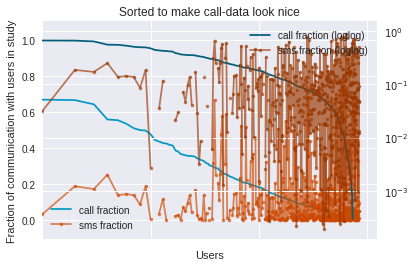

In [6]:
colorFun = lambda rgb: [el/255 for el in rgb]
callFracColorNormal = colorFun([2, 154, 196])
callFracColorLog = colorFun([1, 95, 121])
smsFracColorNormal = colorFun([204, 71, 0])
smsFracColorLog = colorFun([153, 54, 0])
fig, ax0 = plt.subplots()
ax0.plot(callFracArr, color=callFracColorNormal, label="call fraction")
ax0.plot(smsFracArr, '.-', color=smsFracColorNormal, label="sms fraction", alpha=0.65)
ax1 = plt.twinx(ax0)
ax1.loglog(callFracArr, color=callFracColorLog, label="call fraction (loglog)")
ax1.loglog(smsFracArr, '.-', color=smsFracColorLog, label="sms fraction (loglog)", alpha=0.65)
ax0.set_ylabel("Fraction of communication with users in study")
ax0.set_xlabel('Users')
ax0.set_xticklabels([])
ax0.set_title("Sorted to make call-data look nice")
looseAxesLimits(ax0)
ax0.legend(loc="lower left")
ax1.legend(loc="upper right") 

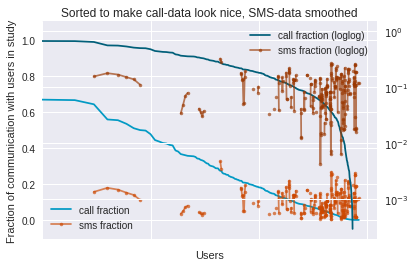

In [7]:
colorFun = lambda rgb: [el/255 for el in rgb]
callFracColorNormal = colorFun([2, 154, 196])
callFracColorLog = colorFun([1, 95, 121])
smsFracColorNormal = colorFun([204, 71, 0])
smsFracColorLog = colorFun([153, 54, 0])
fig, ax0 = plt.subplots()
ax0.plot(callFracArr, color=callFracColorNormal, label="call fraction")
ax0.plot(np.convolve(np.ones(5)/5, smsFracArr, 'same'), '.-',
         color=smsFracColorNormal, label="sms fraction", alpha=0.65)
ax1 = plt.twinx(ax0)
ax1.loglog(callFracArr, color=callFracColorLog, label="call fraction (loglog)")
ax1.loglog(np.convolve(np.ones(5)/5, smsFracArr, 'same'), '.-',
           color=smsFracColorLog, label="sms fraction (loglog)", alpha=0.65)
ax0.set_ylabel("Fraction of communication with users in study")
ax0.set_xlabel('Users')
ax0.set_xticklabels([])
ax0.set_title("Sorted to make call-data look nice, SMS-data smoothed")
looseAxesLimits(ax0)
ax0.legend(loc="lower left")
ax1.legend(loc="upper right") 

In [8]:
cdf = pd.DataFrame.from_dict(callDct2, orient="index").apply(lambda x: x/np.sum(x))  # Normalize
sdf = pd.DataFrame.from_dict(smsDct2, orient="index").apply(lambda x: x/np.sum(x))
cmb = pd.concat((cdf, sdf))
cmb = cmb.groupby(cmb.index).sum()
cmb

,u0001,u0002,u0003,u0004,u0005,u0006,u0007,u0008,u0009,u0010,...,u0795,u0797,u0799,u0800,u0801,u0803,u0804,u0806,u0808,u0809
u0001,0.303030,0.833992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0002,1.661255,0.158103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0003,NaN,NaN,0.205479,0.652362,1.78125,0.025669,0.958042,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0004,NaN,NaN,1.200424,NaN,NaN,1.462663,0.204545,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0005,NaN,NaN,0.575832,NaN,0.18750,0.333768,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0006,NaN,NaN,0.018265,1.104773,NaN,0.096774,0.428322,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0007,NaN,NaN,NaN,0.242865,NaN,0.081126,0.409091,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.041923,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.383333,0.120048,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
u0010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The data is quite sparse. It's hard to see, but there's a black dot when the data i _not_ `NaN`.

First plot is for calls, second for SMS.

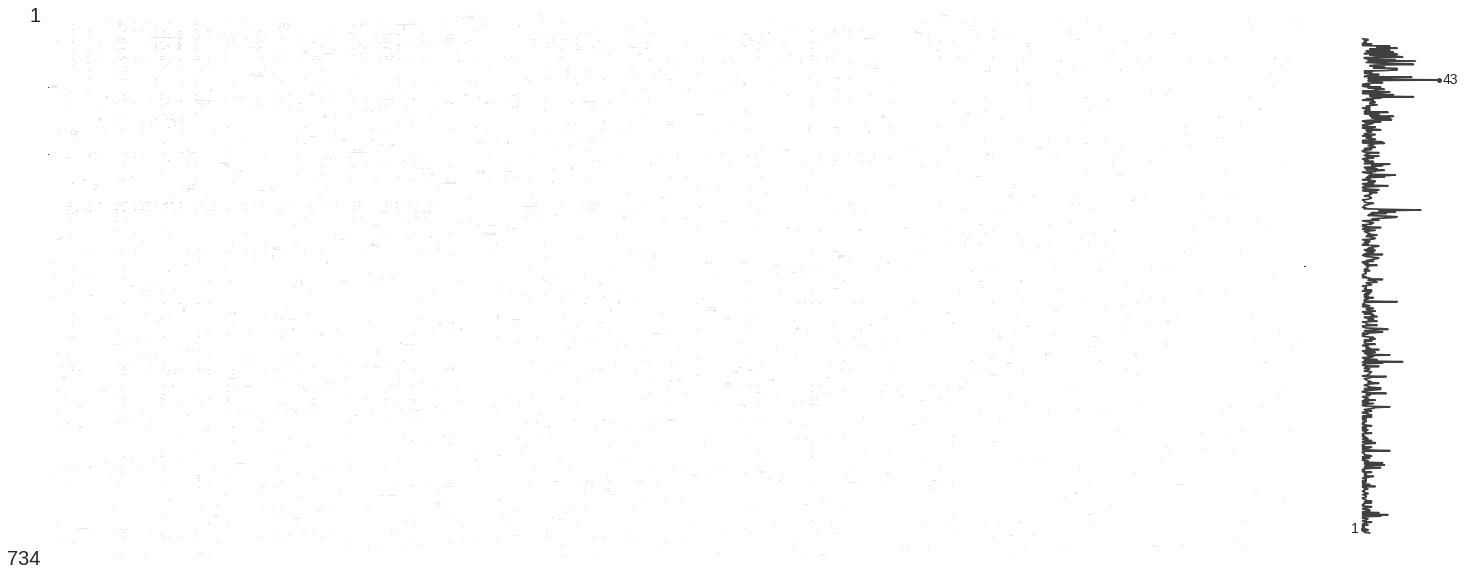

In [9]:
msno.matrix(cdf)

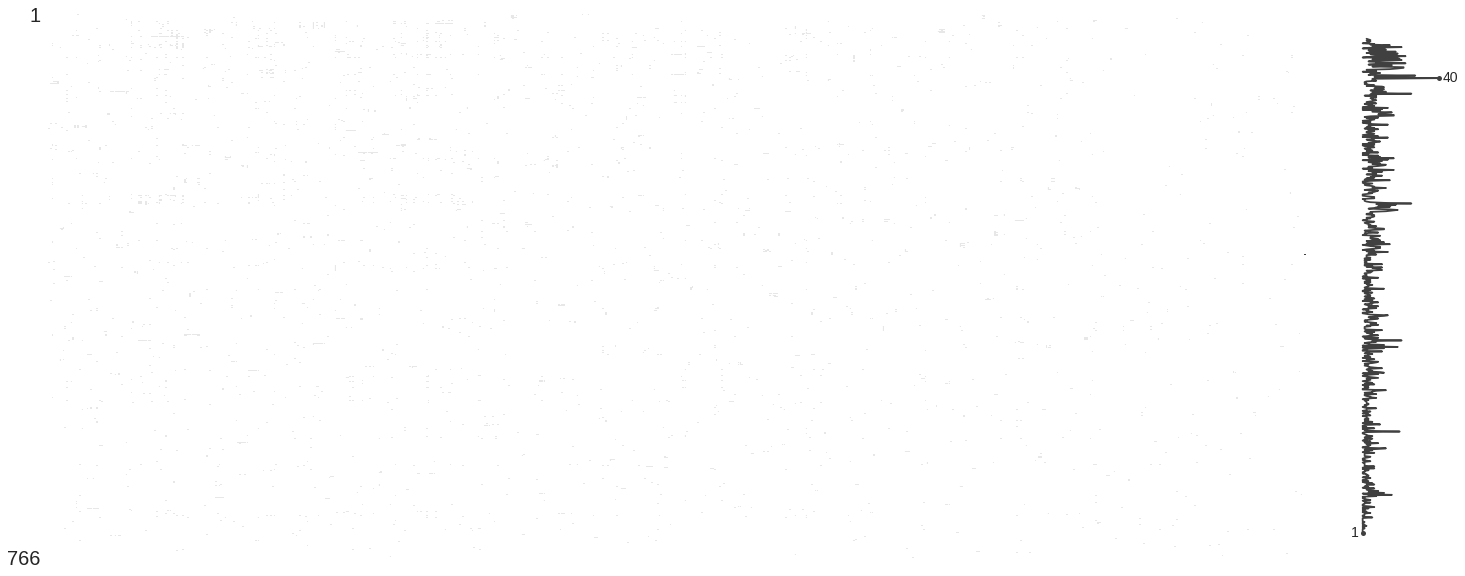

In [10]:
msno.matrix(sdf)

Adjacency matrix excluding telephone numbers which is not part of the Social Fabric study.

In [11]:
g = nx.from_dict_of_lists({k:callDct[k].keys() for k in callDct})

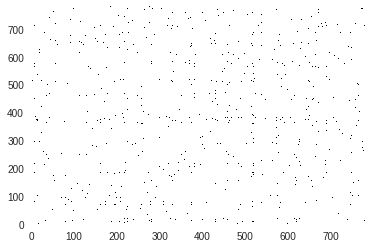

In [12]:
gm = nx.adjacency_matrix(g)
fig, ax = plt.subplots()
ax.pcolorfast(gm.todense())